In [1]:
# sklearn utilties 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# classifiers  
from sklearn.linear_model import LogisticRegression
# from sklearn.dummy import DummyClassifier
# from sklearn.ensemble import RandomForestClassifier

# sampling 
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# useful libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# more lib
import os, sys
import dropbox
from zipfile import ZipFile
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from utils.data_extract_utils import extract_zip, extract_features_from_bureau, get_clean_credit, remove_highly_correlated_columns,extract_features_from_installments_payments
import gc



Bad key "text.kerning_factor" on line 4 in
/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# helper functions
def get_missing_data_info(df):
    """
    add description .. 
    
    """
    num_of_instance, _ = df.shape
    #print(num_of_instance)
    names = {'index': 'feature', 
             0: 'PERC_missing_data'}
    
    missing_df = (df.isnull() \
        .sum(axis=0)/num_of_instance) \
        .to_frame() \
        .reset_index() \
        .rename(columns=names) \
        .sort_values(by='PERC_missing_data', ascending=False) \
        .reset_index(drop=True)
    
    d = {}
    # no missing 
    zero = missing_df[missing_df['PERC_missing_data'] == 0]
    d['x = 0'] = list(zero.feature)
    le_10 = missing_df[(missing_df['PERC_missing_data'] > 0.0) & (missing_df['PERC_missing_data'] <= 0.1)]
    
    d['0< x <= 25'] = list(missing_df[(missing_df['PERC_missing_data'] > 0.0) & (missing_df['PERC_missing_data'] <= 0.25)].feature)
    
    d['25 < x <= 50'] = list(missing_df[(missing_df['PERC_missing_data'] > 0.25) & (missing_df['PERC_missing_data'] <= 0.5)].feature)
    
    d['x > 50'] = list(missing_df[missing_df['PERC_missing_data'] > 0.5].feature)
    
    return missing_df, d

def combine(x):
    if x == "Incomplete higher" or x == 'Academic degree':
        return 'Higher education'
    elif x == 'Lower secondary':
        return 'Secondary / secondary special'
    else:
        return x
    
def get_columns_x(application, col_name, threshhold):
    temp = application.loc[:, col_name].value_counts(dropna=False).to_frame().reset_index()
    temp.columns = ['values', 'count']
    temp['prec of val'] = temp['count'].apply(lambda x: x/application.shape[0])
    groups = list(temp.loc[temp['prec of val'] <threshhold, 'values'].values)
    
    return groups

def corr_with_target(application):
    target = application.loc[application['TARGET'].notnull(), 'TARGET']
    train_df = application.loc[application['TARGET'].notnull(), :].drop(columns=['TARGET']).select_dtypes(include = [int, float])

    corr_col = [i for i in train_df.columns if i not in ['index', 'SK_ID_CURR']]
    corr_arr = pd.Series([target.corr(train_df[i]) for i in corr_col])
    
    name = pd.Series(corr_col)
    df_dict = {'feature': name, 'corr with target': corr_arr}
    corr_df = pd.DataFrame(df_dict).sort_values(by = 'corr with target',ascending=False)
    
    return corr_df

def clean_application(data):

    # get table 
    application = data['application_train'].copy().append(data['application_test']).reset_index()
    
    # fix categorical data 

    # 'NAME_TYPE_SUITE'
    application.replace({'NAME_TYPE_SUITE': ['Children', 
                                             'Other_B', 
                                             'Other_A', 
                                             'Group of people']}, 
                        'Other', inplace = True)


    # 'NAME_INCOME_TYPE'
    application.replace({'NAME_INCOME_TYPE': ['Unemployed', 
                                              'Student', 
                                              'Businessman', 
                                              'Maternity leave']}, 
                        'Other', inplace=True)

    # NAME_EDUCATION_TYPE
    application['NAME_EDUCATION_TYPE'] = application['NAME_EDUCATION_TYPE'].apply(lambda x: combine(x))

    #'NAME_HOUSING_TYPE'
    application.replace({'NAME_HOUSING_TYPE': ['Municipal apartment', 
                                               'Office apartment', 
                                               'Co-op apartment']}, 
                        'Rented apartment', inplace = True)

    # OCCUPATION_TYPE
    other_occp = get_columns_x(application, 'OCCUPATION_TYPE', 0.03)  
    application.replace({'OCCUPATION_TYPE': other_occp}, 
                        'Other', inplace = True)

    # ORGANIZATION_TYPE
    other_org = get_columns_x(application, 'ORGANIZATION_TYPE', 0.02)  
    application.replace({'ORGANIZATION_TYPE': other_org}, 
                        'Other', inplace = True)

    # drop cat features - low variance and high % of missing val
    application.drop(columns = ['FONDKAPREMONT_MODE', 
                                'HOUSETYPE_MODE', 
                                'WALLSMATERIAL_MODE', 
                                'EMERGENCYSTATE_MODE'], 
                     axis = 1, inplace=True)

    ## label encoder for binary values
    bin_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

    replace_dict = {'CODE_GENDER': {'M': 0, 'F': 1},
                    'FLAG_OWN_CAR': {'Y': 0, 'N': 1}, 
                    'FLAG_OWN_REALTY':{'Y': 0, 'N': 1},
                   'NAME_EDUCATION_TYPE': {'Higher education': 1,
                                          'Secondary / secondary special': 0}}

    application.replace(replace_dict, inplace=True)


    # remove few instances with low appearance
    application = application.loc[application['CODE_GENDER'] != 'XNA', :]
    application = application.loc[application['NAME_FAMILY_STATUS'] != 'Unknown', :]


    # drop_features > 50% of missing vals (both: cat, num)
    cols = [i for i in list(application.columns) if i != 'TARGET']
    _, missing_dict = get_missing_data_info(application.loc[:,cols])
    drop_cols = missing_dict['x > 50']

    # keep EXT_SOURCE_1 --> highly corr with target 
    drop_cols.remove('EXT_SOURCE_1')
    application.drop(columns = drop_cols, axis = 1, inplace = True)

    # Numerical features 

    ## DAYS_EMPLOYED
    application['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    application['DAYS_EMPLOYED'] =application['DAYS_EMPLOYED'].apply(lambda x: abs(x))

    application['BIRTH_IN_YEARS'] = application['DAYS_BIRTH'].apply(lambda x: abs(x)/365)


    # add new features 
    application['ALL_EXT_SOURCE_MEAN']=application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    application['PAYMENT_RATE'] = application['AMT_ANNUITY']/application['AMT_CREDIT']
    application['INCOME_PER_PERSON'] = application['AMT_INCOME_TOTAL']/application['CNT_FAM_MEMBERS']
    application['INCOME_CREDIT_IN_PERCENTAGE '] = application['AMT_INCOME_TOTAL']/application['AMT_CREDIT']
    application['ANNUITY_INCOME_IN_PERCENTAGE'] = application['AMT_ANNUITY']/application['AMT_INCOME_TOTAL']

    doc_cols = [i for i in list(application.columns) if 'FLAG_DOCUMENT' in i]
    application['ALL_FLAG_DOCUMENT_SUM']=application[doc_cols].mean(axis = 1)

    ## drop indiv doc columns + other useless columns 
    application.drop(columns = doc_cols, axis = 1, inplace = True)
    application.drop(columns = ['FLAG_CONT_MOBILE','FLAG_MOBIL', 'DAYS_BIRTH'], axis = 1, inplace = True)
    

    if 'index' in list(application.columns):
        application.drop(columns = ['index'], axis = 1, inplace = True)
        print('index column removed')

    return application

def join_tables(data):
    # credit card table
    cc = get_clean_credit(data['credit_card_balance'])
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
    cc_agg.columns = pd.Index(list(map(lambda x: 'CC' + '_' + x[0] + '_' + x[1], list(cc_agg.columns))))
    
    # main aplication 
    train_test = clean_application(data)
    train_test.set_index('SK_ID_CURR', inplace=True, drop=False)
    
    # burea/balance table
    bb = extract_features_from_bureau(data['bureau'], data['bureau_balance'])
    
    # isntallments payments table
    ip = extract_features_from_installments_payments(data['installments_payments'])
    
    # join table
    df = pd.concat([train_test, bb, ip, cc_agg], axis=1) 
    df = df.reset_index(drop=True)
    df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('Int64')
    # for safety 
    df = df.loc[df['SK_ID_CURR'].notnull(), :]
    
    # clean memory
    del cc
    del cc_agg
    del train_test
    del bb
    del ip
    gc.collect()
    
    return df


In [3]:
# Connect to dropbox
dbx = dropbox.Dropbox('cHV7yAR0J6YAAAAAAAAAAVQ1NLCrOwerbaNltPWHslYXKuUTJ5_wfgJsuFcmx83o')

data = {}
for entry in dbx.files_list_folder('').entries:
    response = dbx.files_download('/{}'.format(entry.name))
    
    if 'zip' in entry.name:
        content = extract_zip(response[1].content)
    
        for file in content:
            df = pd.read_csv(file[1])
            data[entry.name.replace('.csv.zip', '')] = df
            


In [4]:
main_df = join_tables(data)
main_df.shape

/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_SUM'] = dpd_counts_sum['SK_DPD']
/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']


index column removed


(356249, 104)

In [7]:
X, y = (main_df.loc[(main_df['TARGET'].notnull()) & (main_df['SK_ID_CURR'].notnull()), :].drop(columns=['TARGET', 'SK_ID_CURR'], axis=1), 
        main_df.loc[(main_df['TARGET'].notnull()) & (main_df['SK_ID_CURR'].notnull()), 'TARGET'])

# test set for kaggle
test_ids = main_df.loc[(main_df['TARGET'].isnull()) & (main_df['SK_ID_CURR'].notnull()), 'SK_ID_CURR']
X_test = main_df.loc[(main_df['TARGET'].isnull()) & (main_df['SK_ID_CURR'].notnull()), :].drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)

X.shape, y.shape, X_test.shape

((307505, 102), (307505,), (48744, 102))

In [8]:
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = list(X.select_dtypes(include=[int, float]).columns)
len(cat_cols),len(num_cols)

(9, 93)

In [9]:
## pipelines

# one hot encoding 
categorical_pipe = Pipeline(steps=[
    ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
  ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# numerical 
numerical_pipe = Pipeline(steps=[
    ('num_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ("scale", StandardScaler())  
])


# transform columns 
column_transformer = ColumnTransformer(transformers=[    
    ('num_pip', numerical_pipe, num_cols),
    ('cat_pipe', categorical_pipe, cat_cols)
])

In [10]:
# apply preprocessing to X
X_trans = column_transformer.fit_transform(X)

In [11]:
# smote sampling
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_trans,y)

X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [13]:
logreg= LogisticRegression(solver='lbfgs', random_state=42,max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

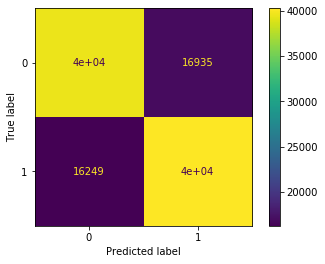

In [15]:
y_pred_log = logreg.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, ).plot()
plt.show()

In [16]:
logreg.classes_

array([0., 1.])

In [17]:
y_score =logreg.decision_function(X_val)

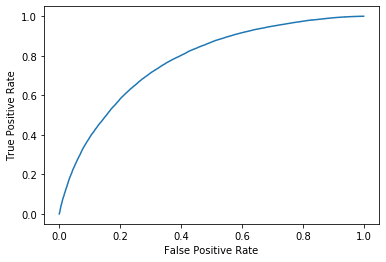

In [21]:
y_score =logreg.decision_function(X_val)
fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [33]:
print('classifaction report on validation set')
print(classification_report(y_val, y_pred, labels=[0,1]))

classifaction report on validation set
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     56536
           1       0.70      0.71      0.71     56536

    accuracy                           0.71    113072
   macro avg       0.71      0.71      0.71    113072
weighted avg       0.71      0.71      0.71    113072



In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)

SGDClassifier()

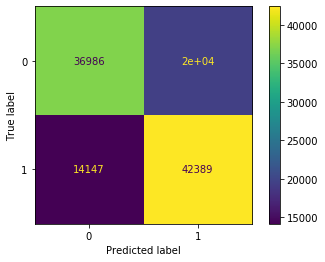

In [26]:
y_pred_sgd = sgd.predict(X_val)
cm_sgd = confusion_matrix(y_val, y_pred_sgd)
cm_display = ConfusionMatrixDisplay(cm_sgd).plot()
plt.show()

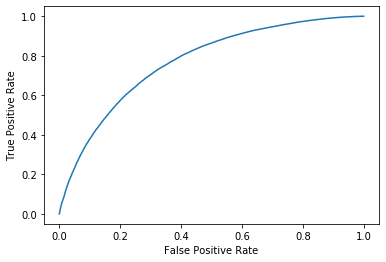

In [27]:
y_score_sgd =sgd.decision_function(X_val)
fpr, tpr, _ = roc_curve(y_val, y_score_sgd, pos_label=sgd.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

In [32]:
print('classifaction report on validation set')
print(classification_report(y_val, y_pred_sgd, labels=[0,1]))

classifaction report on validation set
              precision    recall  f1-score   support

           0       0.72      0.65      0.69     56536
           1       0.68      0.75      0.72     56536

    accuracy                           0.70    113072
   macro avg       0.70      0.70      0.70    113072
weighted avg       0.70      0.70      0.70    113072



In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
# y_pred_knn = knn.predict(X_val)
# # cm_knn = confusion_matrix(y_val, y_pred_knn)
# # cm_display = ConfusionMatrixDisplay(cm_knn).plot()
# # plt.show()
### takes too long to compute :(

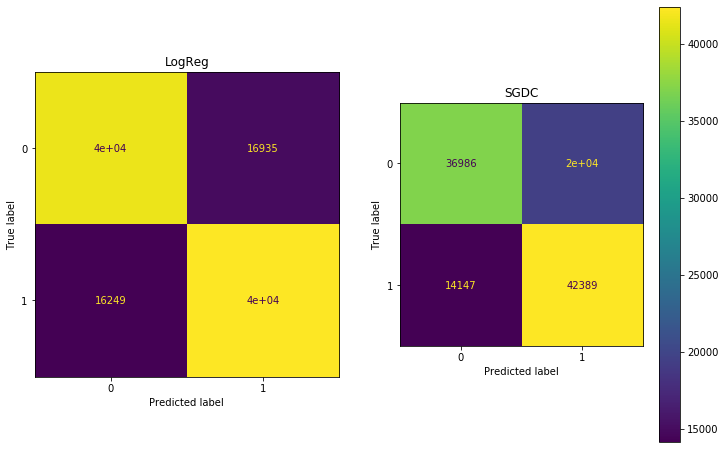

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

y_pred_log = logreg.predict(X_val)
cm_log = confusion_matrix(y_val, y_pred_log)

y_pred_sgd = sgd.predict(X_val)
cm_sgd = confusion_matrix(y_val, y_pred_sgd)

ConfusionMatrixDisplay(cm_log).plot( ax=ax1, colorbar=False)
ConfusionMatrixDisplay(cm_sgd).plot(ax=ax2)
ax1.set_title('LogReg')
ax2.set_title('SGDC')
plt.show()

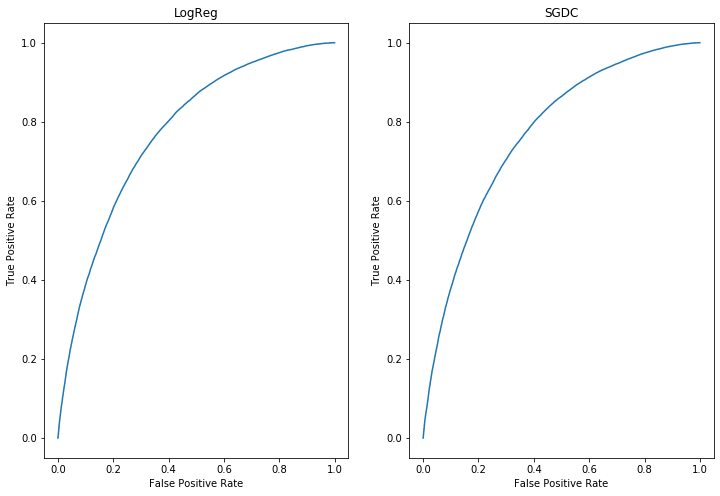

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

y_score =logreg.decision_function(X_val)
fpr1, tpr1, _ = roc_curve(y_val, y_score, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax1)

y_score_sgd =sgd.decision_function(X_val)
fpr2, tpr2, _ = roc_curve(y_val, y_score_sgd, pos_label=sgd.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax2)

ax1.set_title('LogReg')
ax2.set_title('SGDC')
plt.show()